In [1]:
from IPython.core.display import HTML
with open ("../style.css", "r") as file:
    css = file.read()
HTML(css)

# Logistic Regression

In [2]:
import numpy as np

We need to define the sigmoid function $S(t) := \large \frac{1}{1 + \exp(-t)}$.

In [3]:
def sigmoid(t):
    return 1.0 / (1.0 + np.exp(-t))

As we are using NumPy to compute $\exp(t)$, we can feed this function with a `numpy` array to compute the sigmoid function for every element of the array:

In [4]:
sigmoid(np.array([-1.0, 0.0, 1.0]))

array([0.26894142, 0.5       , 0.73105858])

Let us check the limits.  In the lecture we have seen that
$$ \lim\limits_{x \rightarrow -\infty} S(x) = 0 \quad \mbox{and} \quad 
   \lim\limits_{x \rightarrow +\infty} S(x) = 1 
$$

In [5]:
sigmoid(-100), sigmoid(100)

(3.7200759760208356e-44, 1.0)

In [6]:
1.0 - 3.7200759760208356e-44

1.0

Next, we define the natural logarithm of the sigmoid function.  If we implement this as `log(sigmoid(t))` we will get overflow issues for negative values of $t$ such that $t < -1000$ as the expression `np.exp(-t)` will overflow. 

In [7]:
np.exp(1000)

/var/folders/j0/9pg05lc57pd41f8b7d_b7sv40000gq/T/ipykernel_1109/2006519253.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(1000)


inf

In [8]:
-np.log(1 + np.exp(1000))

/var/folders/j0/9pg05lc57pd41f8b7d_b7sv40000gq/T/ipykernel_1109/4196205950.py:1: RuntimeWarning: overflow encountered in exp
  -np.log(1 + np.exp(1000))


-inf

This is not what we expected.  

In [9]:
np.exp(100)

2.6881171418161356e+43

On the other hand, for $t < -100$ we have that $1 + \exp(-t) \approx \exp(-t)$:

In [10]:
1 + np.exp(-(-100)) == np.exp(-(-100))

True

Therefore, if $t < -100$ we have:
$$ 
\begin{array}{lcl}
         \ln\left(\large\frac{1}{1+\exp(-t)}\right) 
  & = & -\ln\bigl(1+\exp(-t)\bigr) \\
  & \approx & -\ln\bigl(\exp(-t)\bigr)  \\
  & = & t
\end{array}
$$
Hence $\ln\bigl(S(t)\bigr) \approx t$ for $t < -100$. The following implementation uses this approximation.

In [11]:
def logSigmoid(t):
    if t > -100:
        return -np.log(1.0 + np.exp(-t))
    else:
        return t

In [13]:
logSigmoid(-99)

-99.0

Given a feature matrix `X` and a vector `y` of classification outputs, the *log-likelihood function* $\ell\ell(\textbf{X}, \textbf{y},\textbf{w})$ is mathematically defined as follows:
$$\ell\ell(\mathbf{X},\mathbf{y},\mathbf{w}) = 
 \sum\limits_{i=1}^N \ln\Bigl(S\bigl(y_i \cdot(\mathbf{x}_i^\top \cdot \mathbf{w})\bigr)\Bigr) =
 \sum\limits_{i=1}^N L\bigl(y_i \cdot(\mathbf{x}_i^\top \cdot \mathbf{w})\bigr)
$$
The value of the *log-likelihood function* is interpreted as the logarithm of the probability that our model of the classifier predicts the observed values $y_i$ when the features are given by the vector $\textbf{x}_i$ for all $i\in\{1,\cdots,N\}$.

The arguments $\textbf{X}$, $\textbf{y}$, and $\textbf{w}$ are interpreted as follows:
* $\textbf{X}$ is the feature matrix, $\textbf{X}[i]$ is the $i$-th feature vector, i.e we have
  $\textbf{X}[i] = \textbf{x}_i^\top$.
         
  Furthermore, it is assumed that $\textbf{X}[i][0]$ is 1.0 for all $i$.  
  Hence we have a feature that is constant for all examples.
* $\textbf{y}$ is the output vector, $\textbf{y}[i] \in \{-1,+1\}$ for all $i$.
* $\textbf{w}$ is the weight vector.

In [14]:
def ll(X, y, w):   
    return np.sum([logSigmoid(y[i] * (X[i] @ w)) for i in range(len(X))])

The function $\mathtt{gradLL}(\mathbf{x}, \mathbf{y}, \mathbf{w})$ computes the gradient of
the log-likelihood according to the formula
$$ \frac{\partial\quad}{\partial\, w_j}\ell\ell(\mathbf{X},\mathbf{y};\mathbf{w}) =
   \sum\limits_{i=1}^N y_i \cdot x_{i,j} \cdot  S(-y_i \cdot \mathbf{x}_i \cdot \mathbf{w}).
$$
The different components of this gradient are combined into a vector.
The arguments are the same as the arguments to the function $\ell\ell$ that computes the log-likelihood, i.e.
* $\textbf{X}$ is the feature matrix, $\textbf{X}[i]$ is the transpose of $i$-th feature vector.
* $\textbf{y}$ is the output vector, $\textbf{y}[i] \in \{-1,+1\}$ for all $i$.
* $\textbf{w}$ is the weight vector.

In [15]:
def gradLL(X, y, w):
    Gradient = []
    for j in range(len(X[0])):
        L = [y[i] * X[i][j] * sigmoid(-y[i] * (X[i] @ w)) for i in range(len(X))]
        Gradient.append(sum(L))
    return np.array(Gradient)

The data we want to investigate is stored in the file `'exam.csv'`.  The first column of this file is an integer from the set $\{0,1\}$.  The number is $0$ if the corresponding student has failed the exam and is $1$ otherwise.  The second column is a floating point number that lists the number of hours that the student has studied for the given exam.

In [16]:
import csv

The file `exam.csv` contains fictional data about an exam. The first column contains the number `0` if the student has failed the exam and `1` otherwise.  The second column contains the number of hours the student has studied for the given exam.

In [17]:
!cat exam.csv || type exam.csv

Pass,Hours
0,0.50
0,0.75
0,1.00
0,1.25
0,1.50
0,1.75
1,1.75
0,2.00
1,2.25
0,2.50
1,2.75
0,3.00
1,3.25
0,3.50
1,4.00
1,4.25
1,4.50
1,4.75
1,5.00
1,5.50


In [18]:
with open('exam.csv') as file:
    reader = csv.reader(file, delimiter=',')
    count  = 0  # line count
    Pass   = []
    Hours  = []
    for row in reader:
        if count != 0:  # skip header
            Pass .append(float(row[0]))
            Hours.append(float(row[1]))
        count += 1

To proceed, we will plot the data points.  To this end we transform the lists `Pass` and `Hours` into numpy arrays.

In [19]:
y = np.array(Pass)
x = np.array(Hours)

In [20]:
import matplotlib.pyplot as plt
import seaborn           as sns

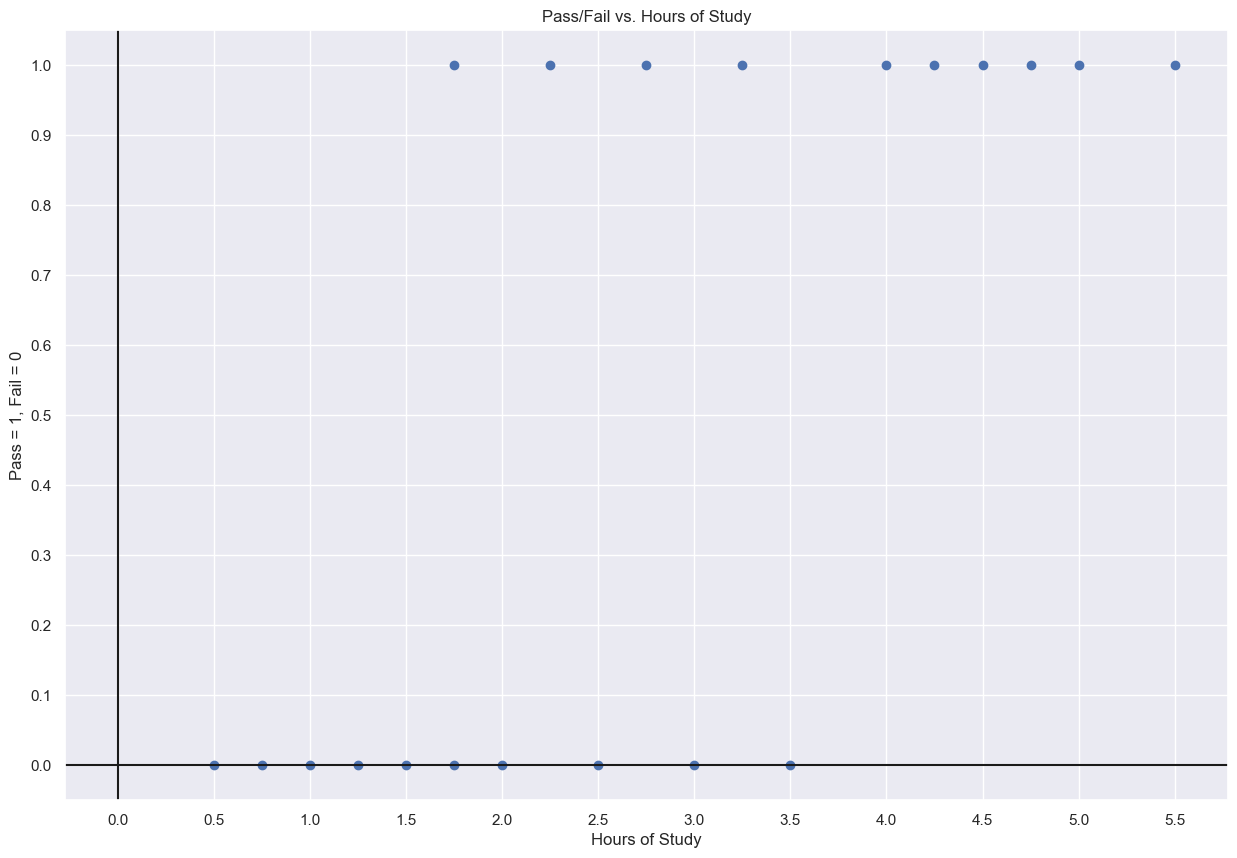

In [21]:
plt.figure(figsize=(15, 10))
sns.set(style='darkgrid')
plt.title('Pass/Fail vs. Hours of Study')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('Hours of Study')
plt.ylabel('Pass = 1, Fail = 0')
plt.xticks(np.arange(0.0, 6.0, step=0.5))
plt.yticks(np.arange(-0.0, 1.1, step=0.1))
plt.scatter(x, y, color='b')

The number of students is stored in the variable `n`.

In [22]:
n = len(y)
n

20

We have to turn the vector `x` into the feature matrix `X`.

In [23]:
x.shape

(20,)

In [25]:
X = np.reshape(x, (n, 1))
X

array([[0.5 ],
       [0.75],
       [1.  ],
       [1.25],
       [1.5 ],
       [1.75],
       [1.75],
       [2.  ],
       [2.25],
       [2.5 ],
       [2.75],
       [3.  ],
       [3.25],
       [3.5 ],
       [4.  ],
       [4.25],
       [4.5 ],
       [4.75],
       [5.  ],
       [5.5 ]])

We append the number $1.0$ to every row of `X`. `axis=1` specifies that the ones are appended to each column.  If we had specified `axis=0` instead, the number of rows would have doubled.

In [26]:
X = np.append(X, np.ones((n, 1)), axis=1)
X

array([[0.5 , 1.  ],
       [0.75, 1.  ],
       [1.  , 1.  ],
       [1.25, 1.  ],
       [1.5 , 1.  ],
       [1.75, 1.  ],
       [1.75, 1.  ],
       [2.  , 1.  ],
       [2.25, 1.  ],
       [2.5 , 1.  ],
       [2.75, 1.  ],
       [3.  , 1.  ],
       [3.25, 1.  ],
       [3.5 , 1.  ],
       [4.  , 1.  ],
       [4.25, 1.  ],
       [4.5 , 1.  ],
       [4.75, 1.  ],
       [5.  , 1.  ],
       [5.5 , 1.  ]])

Currently, the entries in the vector `y` are either $0$ or $1$.  These values need to be transformed to $-1$ and $+1$. 

In [27]:
y = 2 * y - 1
y

array([-1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.])

As we have no real clue about the weights, we set them to $0$ initially.

In [28]:
import gradient_ascent

In [29]:
start   = np.zeros((2,))
eps     = 10 ** -8
f       = lambda w: ll(X, y, w)
gradF   = lambda w: gradLL(X, y, w)
w, _, _ = gradient_ascent.findMaximum(f, gradF, start, eps, True)
beta    = w[1]
gamma   = w[0]
print(f'model: P(pass|hours) = S({beta} + {gamma} * hours)')

cnt = 1, f([1.0125 0.    ]) = -20.427214788226877
gradient = [-14.60175171  -7.83817142]
decrementing: alpha = 0.05
cnt = 1, f([ 0.28241241 -0.39190857]) = -11.798462600406191
gradient = [ 2.07472273 -1.86909472]
incrementing: alpha = 0.06
cnt = 2, f([ 0.40689578 -0.50405425]) = -11.504550930112226
gradient = [-1.47992672 -2.81323039]
incrementing: alpha = 0.072
cnt = 3, f([ 0.30034105 -0.70660684]) = -11.341166117456822
gradient = [ 5.28536212 -0.61506731]
incrementing: alpha = 0.08639999999999999
cnt = 4, f([ 0.75699634 -0.75974866]) = -12.380384677815528
gradient = [-8.45361865 -4.87840952]
decrementing: alpha = 0.043199999999999995
cnt = 4, f([ 0.39180002 -0.97049595]) = -10.73608274923745
gradient = [ 4.60230176 -0.54684122]
incrementing: alpha = 0.05183999999999999
cnt = 5, f([ 0.63038334 -0.9988442 ]) = -10.63970464449448
gradient = [-3.64326485 -3.03151033]
incrementing: alpha = 0.062207999999999986
cnt = 6, f([ 0.40374312 -1.18742839]) = -10.641424074358248
gradient = [6.82809

cnt = 136, f([ 1.50339703 -4.06845455]) = -8.029926062945668
gradient = [-0.03667696 -0.0152309 ]
decrementing: alpha = 0.03559249042377587
cnt = 136, f([ 1.5020916  -4.06899665]) = -8.029891978962931
gradient = [-0.00705903 -0.00517071]
incrementing: alpha = 0.04271098850853105
cnt = 137, f([ 1.5017901 -4.0692175]) = -8.02989012072284
gradient = [ 0.00042666 -0.00260225]
incrementing: alpha = 0.05125318621023726
cnt = 138, f([ 1.50181197 -4.06935087]) = -8.029889772305614
gradient = [ 0.00087805 -0.00240853]
incrementing: alpha = 0.06150382345228471
cnt = 139, f([ 1.50186597 -4.069499  ]) = -8.029889371864668
gradient = [ 0.00078632 -0.00239119]
incrementing: alpha = 0.07380458814274164
cnt = 140, f([ 1.50192401 -4.06967549]) = -8.029888909278613
gradient = [ 0.00080285 -0.00232857]
incrementing: alpha = 0.08856550577128997
cnt = 141, f([ 1.50199511 -4.06988172]) = -8.029888378902912
gradient = [ 0.00075656 -0.00227728]
incrementing: alpha = 0.10627860692554796
cnt = 142, f([ 1.502075

Let us plot this function together with the data.

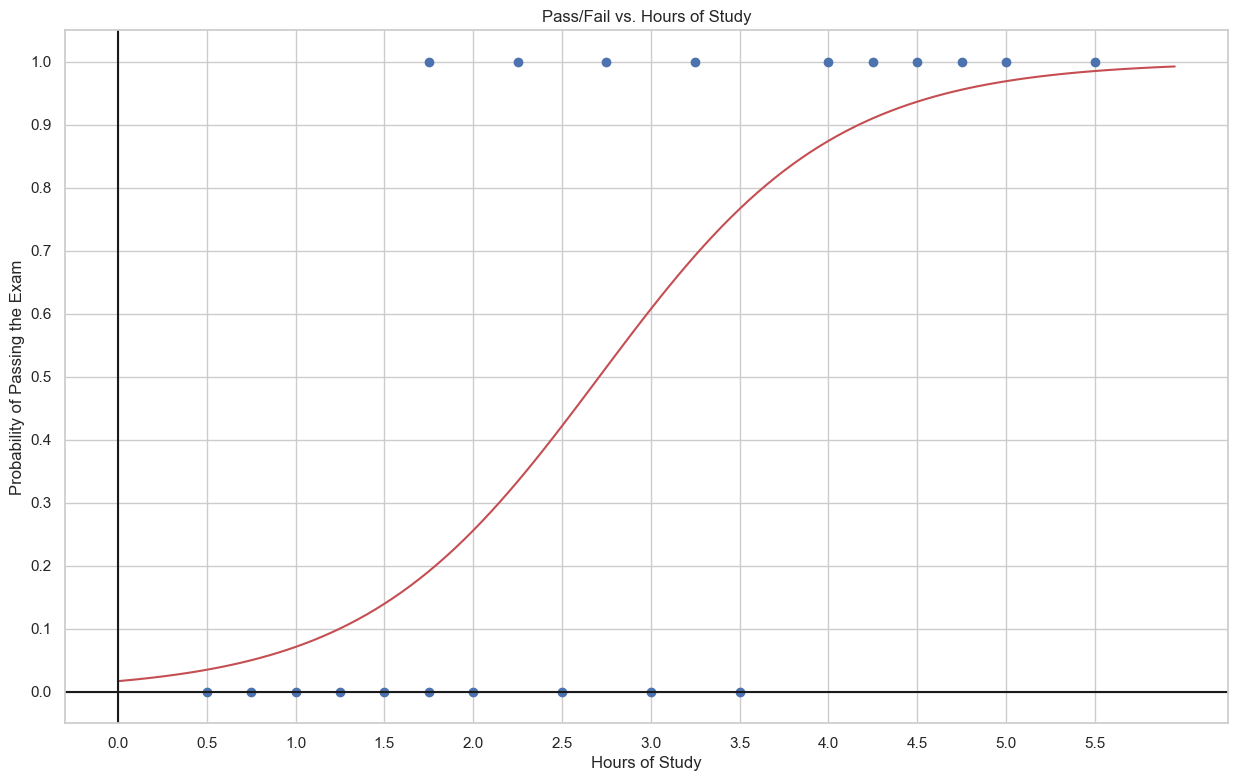

In [30]:
plt.figure(figsize=(15, 9))
sns.set_style('whitegrid')
plt.title('Pass/Fail vs. Hours of Study')
H = np.arange(0.0, 6.0, 0.05)
P = sigmoid(beta + gamma * H)
sns.lineplot(x=H, y=P, color='r')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('Hours of Study')
plt.ylabel('Probability of Passing the Exam')
plt.xticks(np.arange(0.0, 6.0, step=0.5))
plt.yticks(np.arange(-0.0, 1.01, step=0.1))
plt.scatter(x, (y + 1) / 2, color='b')
plt.savefig('exam-probability.pdf')